# Recover reflectance spectra of Color Checker from measurements taken with optimal set of filters

Written by Kate 04/05/22

In [1]:
%cd ".."

import os
import itertools

import rawpy
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

import tape_data
import sensor_data
import munsell_data
import color_utils
import optimization as opt
from experiment import *
from experiment_setup import *

file_prefix = 'data/color_checker/'

/Users/kate/diy-hyperspectral


In [2]:
# Waveplate configurations
wp_hd = Waveplate(tape_data.THICKNESS_HD, tape_data.BIREFRINGENCE_HD)
wp_ss = Waveplate(tape_data.THICKNESS_SS, tape_data.BIREFRINGENCE_SS)

config1  = Config([129.7,   0.0],  75.1, [wp_hd, wp_ss])
config2  = Config([ 45.4,  91.0],   1.7, [wp_hd, wp_ss])
config3  = Config([172.0, 127.5],  83.7, [wp_hd, wp_ss])
config4  = Config([ 92.7,   3.4],   3.0, [wp_hd, wp_ss])
config5  = Config([104.8,  52.8], 179.5, [wp_hd, wp_ss])
config6  = Config([111.5, 102.3],  75.2, [wp_hd, wp_ss])
config7  = Config([125.6, 144.6],  19.6, [wp_hd, wp_ss])
config8  = Config([102.7, 116.5], 130.8, [wp_hd, wp_ss])
config9  = Config([152.7,   9.8],  51.7, [wp_hd, wp_ss])
config10 = Config([177.2,  86.8],  41.9, [wp_hd, wp_ss])

configs = np.array([config1, config2, config3, config4, config5, config6, config7, config8, config9, config10])

  0%|          | 0/10 [00:00<?, ?it/s]

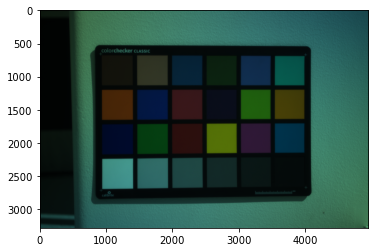

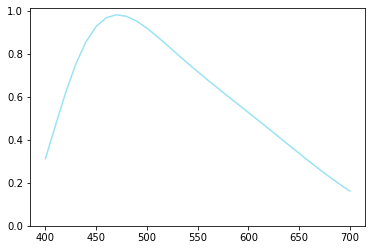

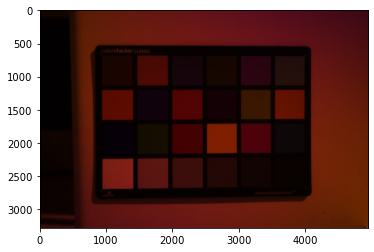

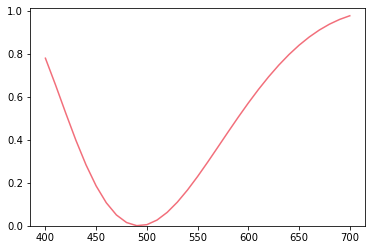

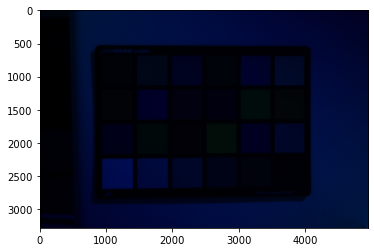

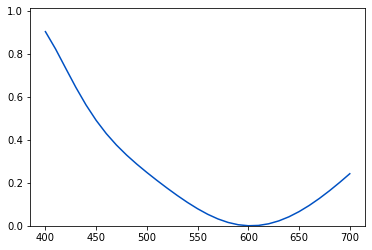

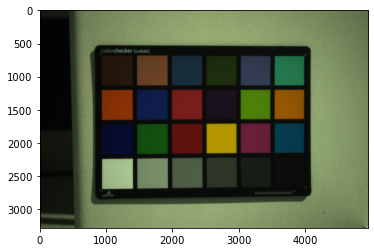

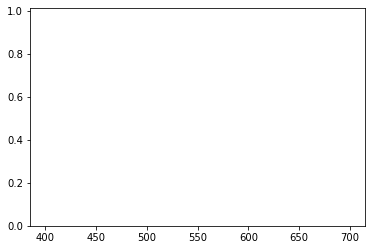

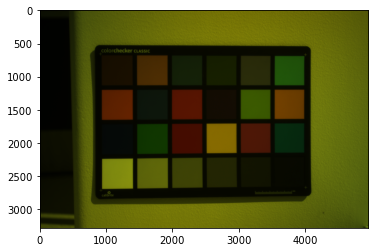

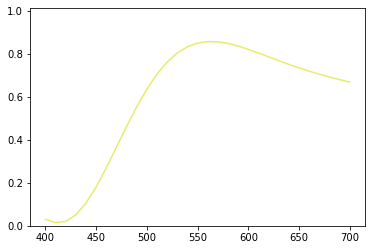

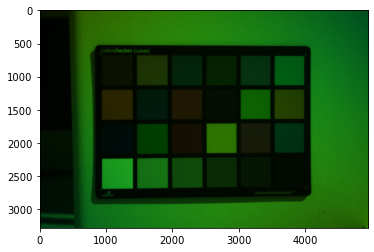

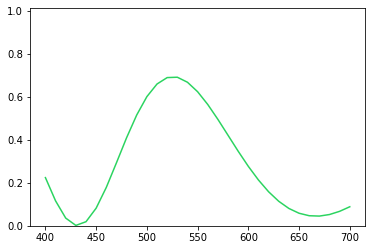

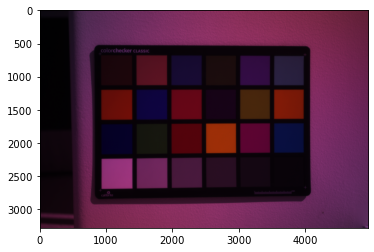

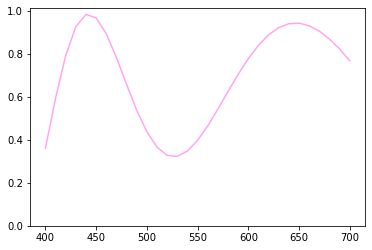

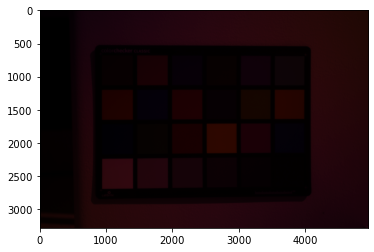

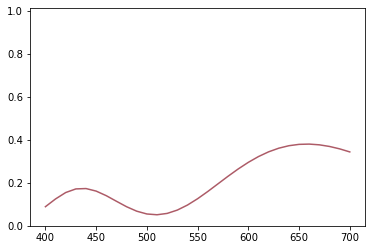

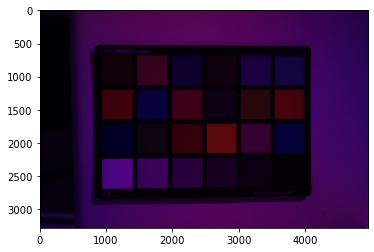

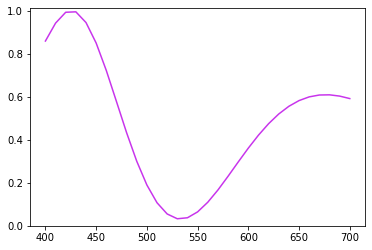

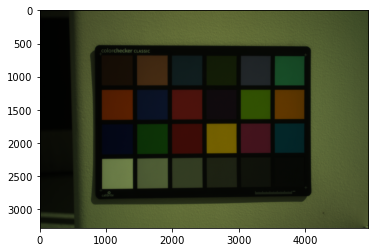

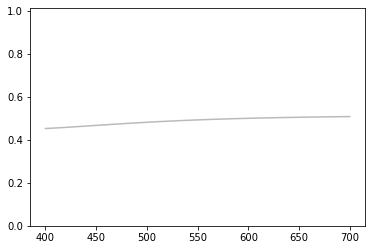

In [3]:
# Load raw images
measurements = []

img_start = 517

for i in trange(len(configs)):
    file_name = file_prefix + "DSC_" + str(img_start + i).zfill(4) + ".NEF"
    meas = FileMeasurement(file_name, i)
    measurements.append(meas)
    
    # Compare measurement photo to (theoretical) transmission spectrum of filters
    meas.show()

    transmission = configs[i].transmission(wavelengths)
    rgb = color_utils.spec2rgb(wavelengths, transmission)

    fig, axs = plt.subplots(1, 1)
    axs.plot(wavelengths, transmission, color = rgb)
    axs.set_ylim(0, 1.01)
    plt.show()

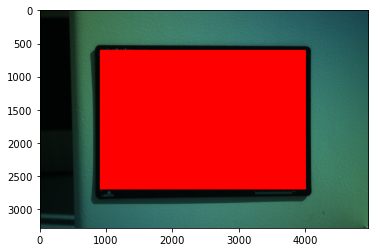

In [4]:
# Crop measurements to boundaries of Color Checker
x0 =  900
x1 = 4000
y0 =  600
y1 = 2700

meas_cp = np.copy(measurements[0].data)
for i in range(y0, y1):
    for j in range(x0, x1):
        meas_cp[i, j, :] = np.array([1., 0., 0.])

plt.imshow(meas_cp)
plt.show()

# Crop images
for m in measurements:
    m.data = m.data[y0:y1, x0:x1, :]

In [5]:
# Find centers of squares
cc_y = np.array([0, 1, 2, 3], dtype = np.uint8) * 520 + 300
cc_x = np.array([0, 1, 2, 3, 4, 5], dtype = np.uint8) * 520 + 280

buf = 50

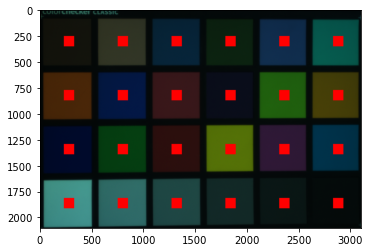

In [6]:
meas_cp = np.copy(measurements[0].data)
for i in range(len(cc_x)):
    x = int(cc_x[i])
    for j in range(len(cc_y)):
        y = int(cc_y[j])
        meas_cp[y-buf:y+buf, x-buf:x+buf, :] = np.array([1., 0., 0.])

plt.imshow(meas_cp)
plt.show()

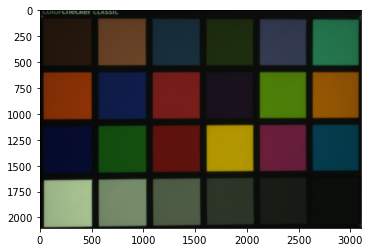

In [7]:
# Load calibration photo with all filters on lens, maximum possible transmittance
wb  = FileMeasurement(file_prefix + "DSC_0516.NEF", 0)

# Crop image
wb.data = wb.data[y0:y1, x0:x1, :]

wb.show()

In [8]:
# Average pixel values in center of color checker squares
for m in measurements:
    cc_tmp = np.zeros((24, 3))
    
    for i in range(len(cc_x)):
        x = int(cc_x[i])
        
        for j in range(len(cc_y)):
            y = int(cc_y[j])
            
            cc_tmp[j*6+i, :] = np.mean(m.data[y-buf : y+buf, x-buf : x+buf, :], axis = (0, 1))
            
    m.data = cc_tmp

In [9]:
cc_wb = np.zeros((24, 3))

for i in range(len(cc_x)):
    x = int(cc_x[i])
    
    for j in range(len(cc_y)):
        y = int(cc_y[j])
        
        cc_wb[j*6+i, :] = np.mean(wb.data[y-buf : y+buf, x-buf : x+buf, :], axis = (0, 1))
        
meas_wb = [ Measurement(cc_wb, 0) ]

In [10]:
# White balance correction
sensor_response_wb, illuminant_coefs_wb = white_balance(meas_wb, sensor_known = False, illum_known = False)
illum_wb = E.transpose() @ illuminant_coefs_wb

100%|██████████| 100/100 [00:13<00:00,  7.23it/s]


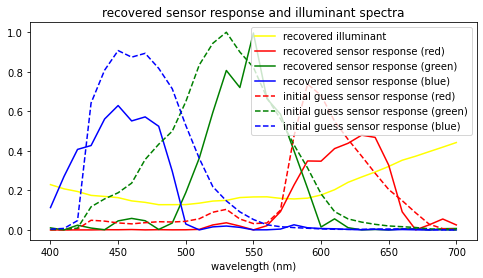

In [11]:
fig, axs = plt.subplots(1, 1, figsize = (8, 4))
axs.plot(wavelengths, illum_wb, color = 'yellow', label = 'recovered illuminant')
axs.plot(wavelengths, sensor_response_wb[0,:], color = 'red', label = 'recovered sensor response (red)')
axs.plot(wavelengths, sensor_response_wb[1,:], color = 'green', label = 'recovered sensor response (green)')
axs.plot(wavelengths, sensor_response_wb[2,:], color = 'blue', label = 'recovered sensor response (blue)')
axs.plot(wavelengths, sensor_response[0,:], color = 'red', linestyle = '--', label = 'initial guess sensor response (red)')
axs.plot(wavelengths, sensor_response[1,:], color = 'green', linestyle = '--', label = 'initial guess sensor response (green)')
axs.plot(wavelengths, sensor_response[2,:], color = 'blue', linestyle = '--', label = 'initial guess sensor response (blue)')
axs.set_xlabel('wavelength (nm)')
axs.set_title('recovered sensor response and illuminant spectra')
plt.legend()
plt.show()

In [12]:
filters = np.array([config.transmission(wavelengths) for config in configs])

# Run optimization without white balance correction
# exp = Experiment(wavelengths, sensor_response, filters, measurements, B, E)
# reconstructed_spectra_no_wb, illuminant_coefs = opt.reconstruct_blind(exp, n_iter = 100, alpha = 1., beta = 1.)
# illum_no_wb = E.transpose() @ illuminant_coefs

# Run optimization with white balance correction
exp = Experiment(wavelengths, sensor_response_wb, filters, measurements, B, E)
reconstructed_spectra, _ = opt.reconstruct_blind(exp, alpha = 1.0, a = illuminant_coefs_wb)

sum squared error (all squares): 2.6740994304176744
avg squared error (per square):  0.11142080960073643


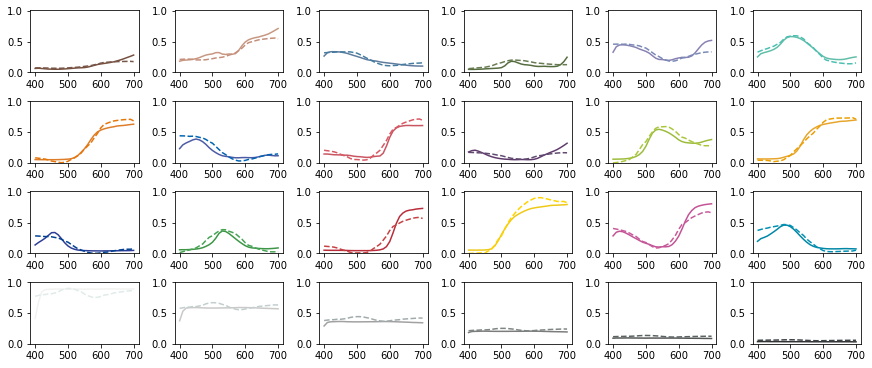

In [13]:
x = 4
y = 6
ns = reconstructed_spectra.shape[0]

sum_sq_err = 0.
fig, axs = plt.subplots(x, y, figsize=(12,5), constrained_layout=True)
 
for i in range(x):
    for j in range(y):
        k = i * y + j
        if k >= ns:
            continue

        gt = cc_spectra[k,:]
        rc = reconstructed_spectra[k,:]
 
        diff = gt - rc
        sum_sq_err += np.sum(diff * diff)

        rgb_gt = color_utils.spec2rgb(wavelengths, gt)
        rgb_rc = color_utils.spec2rgb(wavelengths, rc)

        axs[i,j].plot(wavelengths, gt, label='ground truth ' + str(i), color=rgb_gt, linestyle='-')
        axs[i,j].plot(wavelengths, rc, label='reconstructed ' + str(i), color=rgb_rc, linestyle='--')
        axs[i,j].set_ylim(0, 1.01)
        axs[i,j].set_xticks(np.arange(wavelengths[0], wavelengths[-1]+1., 100.))

print('sum squared error (all squares): ' + str(sum_sq_err))
print('avg squared error (per square):  ' + str(sum_sq_err / ns))